<a href="https://colab.research.google.com/github/Kharazmigroup/forexprj/blob/main/RNN2Forex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#import all libraries
import numpy as np
import pandas as pd
import math
import sklearn
import sklearn.preprocessing
from sklearn.preprocessing import StandardScaler
import datetime
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import yfinance as yf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN,RNN
from keras.layers import Dropout
import IPython
import IPython.display
from math import floor

In [2]:
#set hyper parameters.there is a sequence. the network sees the input days and predicts the other days. seq_len is the sum of inputs and offsets.
seq_len = 3 # taken sequence length as 3
n_steps = seq_len - 1
n_neurons = 800
n_layers = 4
learning_rate = 0.000097
batch_size = 64
dropout_rate = 0.2
num_features = 6

For example, to make a single prediction 24 hours into the future, given 24 hours of history, you might define a window like this:

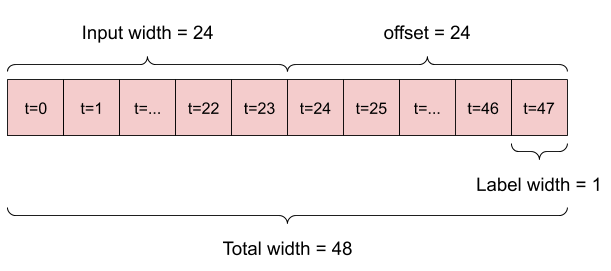

In [3]:
#the data must be normalized so it becomes understandable for machine.
def normalize_data(df):
    min_max_scaler = sklearn.preprocessing.MinMaxScaler()
    df['Open'] = min_max_scaler.fit_transform(df.Open.values.reshape(-1,1))
    df['High'] = min_max_scaler.fit_transform(df.High.values.reshape(-1,1))
    df['Low'] = min_max_scaler.fit_transform(df.Low.values.reshape(-1,1))
    df['Close'] = min_max_scaler.fit_transform(df['Close'].values.reshape(-1,1))
    return df

In [4]:
#spilite data and and make three datasets for training and validation and test.
def spilitData(df_stock_norm):
  n = len(df_stock_norm)
  train_df = df_stock_norm[0:int(n*0.8)]
  val_df = df_stock_norm[int(n*0.8):int(n*0.9)]
  test_df = df_stock_norm[int(n*0.9):]

  num_features = df_stock_norm.shape[1]
  return train_df,val_df,test_df

In [5]:
#because of normalization(between 0 and 1) some values become zero. in calculating the amount of profit, we may encounter divide by zero error. so zero values are deleted with this function.
def drop_zeros(df_stock):
  mask = (df_stock.drop(columns=['Volume']) == 0).any(axis=1)
  removed_rows = df_stock[mask]
  df_stock = df_stock[~mask]

  # Display the removed rows
  print("Removed Rows:")
  print(removed_rows)
  return df_stock

In [6]:
class WindowGenerator():

  def __init__(self,df,input_width, label_width, shift,label_columns=None):
    # Work out the label column indices.
    self.column_indices ={name: i for i, name in enumerate(df.columns)}
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [7]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])
  return inputs, labels

WindowGenerator.split_window = split_window

In [8]:
#this function makes datasets like timeseries so they becomes suitable for a RNN network.
def make_dataset(self, data):

  data = np.array(data, dtype=np.float32)

  ds = tf.keras.utils.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=False,
        batch_size= batch_size)

  ds = ds.map(self.split_window)
  return ds

WindowGenerator.make_dataset = make_dataset

In [9]:
# the model consists of many RNN layers. each layer has many neurons. we increased the number of neurons and saw the accuracy improved.
# after RNN layers, there is a Dense layer that outputs six features.
# to avoid overfitting and also enhancing the model, we added a dropout.
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    layers = [tf.keras.layers.SimpleRNNCell(units=n_neurons)
         for layer in range(n_layers)]
    self.lstm_cell = tf.keras.layers.StackedRNNCells(layers)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dropout = tf.keras.layers.Dropout(dropout_rate)
    #self.dense1 = tf.keras.layers.Dense(64, activation='relu')
    #self.dense2 = tf.keras.layers.Dense(32, activation='relu')
    #self.dropout2 = tf.keras.layers.Dropout(dropout_rate)
    #self.output_layer = tf.keras.layers.Dense(num_features, activation='linear')
    self.dense = tf.keras.layers.Dense(num_features,activation = 'relu')

In [10]:
feedback_model = FeedBack(units=n_neurons, out_steps = n_steps)

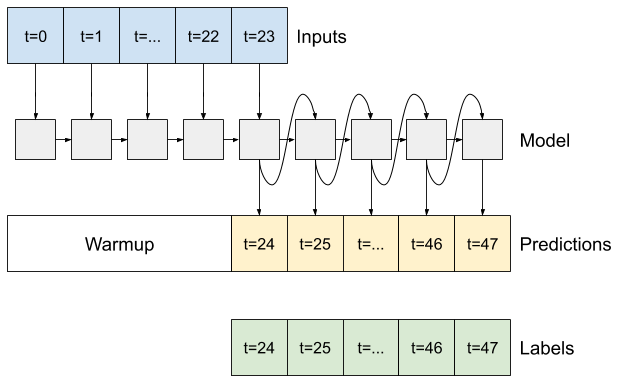

In [11]:
#give the model time to warm up its internal state before making a single prediction
def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)
  # predictions.shape => (batch, features)
  prediction = self.dense(x)

  return prediction, state

FeedBack.warmup = warmup

In [12]:
# this call function as you see in the image above, gets the predictions and gives them as input to the model again..
def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the LSTM state.
  prediction, state = self.warmup(inputs)

  # Insert the first prediction.
  predictions.append(prediction)

  # Run the rest of the prediction steps.
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = self.lstm_cell(x, states=state,
                          training=training)
    if training:
      x = self.dropout(x)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output.
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

FeedBack.call = call

In [13]:
def simple_RNN():
  model = tf.keras.Sequential([
      # First LSTM layer with return_sequences=True to output sequences for subsequent layers
      tf.keras.layers.LSTM(32, return_sequences=True, input_shape=(n_steps, num_features)),

      # Add more LSTM layers if desired
      tf.keras.layers.LSTM(64, return_sequences=True),

      # Add more LSTM layers as needed

      # Final LSTM layer with return_sequences=False to output the final sequence
      tf.keras.layers.LSTM(64, return_sequences=False),

      # Shape => [batch, out_steps*features].
      tf.keras.layers.Dense(n_steps*num_features, kernel_initializer=tf.initializers.zeros()),

      # Shape => [batch, out_steps, features].
      tf.keras.layers.Reshape([n_steps, num_features])
  ])

In [14]:
#MAX_EPOCHS = 150

def compile_and_fit(model, window,epoch, patience=10):
  #early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
   #                                                 patience=patience,
    #                                                mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(learning_rate = learning_rate),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=epoch,
                      validation_data=window.val)
                     # callbacks=[early_stopping])
  return history

In [15]:
 #for ploting and comparing target values and predictions, we need labels..
 #this function seperate inputs and labels from dataset.
 def get_input_Labels(ds):
  ds_inputs = []
  ds_labels = []
  for inputs, labels in ds:
      ds_inputs.append(inputs.numpy())
      ds_labels.append(labels.numpy())
  batch_input = []
  batch_labels = []
  for i in range(len(ds_labels)):
    for j in range(len(ds_labels[i])):
      batch_labels.append(ds_labels[i][j])
      batch_input.append(ds_inputs[i][j])
  return np.array(batch_input),np.array(batch_labels)

In [16]:
def plot_target_predict(test_labels,predictions):
  # ploting the graph
  comp = pd.DataFrame({'Column1':test_labels[:,-1,:][:,3],'Column2':predictions[:,-1,:][:,3]})
  plt.figure(figsize=(20,5))
  plt.plot(comp['Column1'], color='orange', label='Target')
  plt.plot(comp['Column2'], color='red', label='Prediction')
  plt.legend()
  plt.show()

In [17]:
def plot(history):
  acc = history.history['mean_absolute_error']
  val_acc = history.history['val_mean_absolute_error']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(1, len(acc) + 1)

  plt.figure(figsize=(20, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs, acc, label='Training Accuracy')
  plt.plot(epochs, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs, loss, label='Training Loss')
  plt.plot(epochs, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

In [18]:
#it seems ploting is not enough for evaluating model. with this function the amount of profit will be obtained based on predictions.
def calculate_profit(predictions,test_inputs):
  amount_of_profit = 0
  for i in range(1,len(predictions)):
    if (test_inputs[i,-1,3] > test_inputs[i-1,-1,3]):
      if(test_inputs[i-1,-1,3]==0):
            print("i zero...else..."+str(i))
      else:
        if(predictions[i,-1,3] > test_inputs[i-1,-1,3]):
          amount_of_profit += ((min(predictions[i,-1,3],test_inputs[i,-1,3])-test_inputs[i-1,-1,3])/test_inputs[i-1,-1,3]) *10000
        else:
          amount_of_profit += -((test_inputs[i,-1,3] - test_inputs[i-1,-1,3])/test_inputs[i-1,-1,3] * 10000)
    else:
      if(test_inputs[i-1,-1,3]==0):
            print("i zero...else..."+str(i))
      else:
        if (predictions[i,-1,3] <test_inputs[i-1,-1,3] ):
          amount_of_profit += (test_inputs[i-1,-1,3] - max(predictions[i,-1,3],test_inputs[i,-1,3]))/test_inputs[i-1,-1,3] * 10000
        else:
          amount_of_profit += (test_inputs[i,-1,3]-test_inputs[i-1,-1,3])/test_inputs[i-1,-1,3]*1000
  return amount_of_profit

In [19]:
#in dynamic LSTM method, the actual value of the recently predicted
#date is added to the training dataset to rebuild the model to make predictions for data in
#the testing set
def dynamicLSTM(window,test_inputs,test_labels):
  train_inputs,train_labels = get_input_Labels(window.train)
  len_recent_data = 10
  i = 0
  new_predictions = np.empty(shape = (0,n_steps,num_features))
  print("len new pre..."+str(len(new_predictions)))
  iteration = floor(len(test_inputs)/len_recent_data)
  while i < iteration*len_recent_data :
      npredictions = feedback_model.predict(test_inputs[i:i+len_recent_data])
      new_predictions = np.concatenate((new_predictions, npredictions), axis=0)
      combined_data = np.concatenate((train_inputs, test_inputs[i:i+len_recent_data]), axis=0)
      combined_data_labels = np.concatenate((train_labels, test_labels[i:i+len_recent_data]), axis=0)
      window.train = window.make_dataset(combined_data[:,-1,:],64)
      feedback_model.compile(loss=tf.keras.losses.MeanSquaredError(),
                  optimizer=tf.keras.optimizers.Adam(learning_rate = learning_rate),
                  metrics=[tf.keras.metrics.MeanAbsoluteError()])

      history = feedback_model.fit(combined_data,combined_data_labels, epochs=7,
                        validation_data=window.val)
      i += len_recent_data
      print("itrration....."+str(i))
  print("last i...."+str(i))
  npredictions = feedback_model.predict(test_inputs[i:])
  new_predictions = np.concatenate((new_predictions, npredictions), axis=0)
  plot_target_predict(test_labels,new_predictions)
  amount_of_profit = calculate_profit(new_predictions ,test_inputs)
  print("amount of profit....dynamic LSTM..."+str(amount_of_profit))

In [20]:

def run_model(cur_pair,start,end,interval,del_col,epoch):
  df_stock = yf.download(cur_pair, start, end ,interval)
  df_stock = normalize_data(df_stock)
  # Use the drop method to drop the specified columns
  df_stock = df_stock.drop(columns=del_col, axis=1)
  #df_stock = drop_zeros(df_stock)
  train_df,val_df,test_df = spilitData(df_stock)
  multi_window = WindowGenerator(train_df,input_width=n_steps,
                               label_width=1,
                               shift=1)
  multi_window.train = multi_window.make_dataset(train_df)
  multi_window.val = multi_window.make_dataset(val_df)
  multi_window.test = multi_window.make_dataset(test_df)
  history = compile_and_fit(feedback_model, multi_window,epoch)
  predictions = feedback_model.predict(multi_window.test)
  test_inputs,test_labels = get_input_Labels(multi_window.test)
  plot_target_predict(test_labels,predictions)
  profit = calculate_profit(predictions,test_inputs)
  print("profit...."+str(profit))

In [ ]:
run_model('EURUSD=X','2000-01-01','2023-10-14',"",[],100)

In [24]:
data = yf.download('EURUSD=X','2000-01-01','2023-10-14')

weekly_data = data.resample('W').agg({
    'Open': 'first',
    'High': 'max',
    'Low': 'min',
    'Close': 'last',
    'Volume': 'sum'
})
monthly_data = data.resample('M').agg({
    'Open': 'first',
    'High': 'max',
    'Low': 'min',
    'Close': 'last',
    'Volume': 'sum'
})

[*********************100%%**********************]  1 of 1 completed


In [23]:
weekly_data

,Open,High,Low,Close,Volume
Date,,,,,
2003-12-07,1.203398,1.219096,1.194401,1.218695,0
2003-12-14,1.216797,1.230603,1.212298,1.227898,0
2003-12-21,1.218695,1.244199,1.217804,1.238497,0
2003-12-28,1.235697,1.267202,1.235697,1.243194,0
2004-01-04,1.243394,1.264894,1.242993,1.258194,0
...,...,...,...,...,...
2023-09-17,1.071811,1.076542,1.063468,1.063717,0
2023-09-24,1.066826,1.072697,1.061526,1.066155,0
2023-10-01,1.064849,1.065542,1.049186,1.056245,0


In [25]:
monthly_data

,Open,High,Low,Close,Volume
Date,,,,,
2003-12-31,1.203398,1.267202,1.194401,1.259002,0
2004-01-31,1.259002,1.289707,1.234004,1.246805,0
2004-02-29,1.247598,1.292207,1.238099,1.249407,0
2004-03-31,1.253903,1.254107,1.206505,1.231300,0
2004-04-30,1.231194,1.238497,1.176498,1.198294,0
...,...,...,...,...,...
2023-06-30,1.069519,1.101115,1.066416,1.086803,0
2023-07-31,1.090750,1.127574,1.083435,1.102426,0
2023-08-31,1.099759,1.105840,1.076670,1.093255,0


In [ ]:
#create data of the next days.
def future_data():
  data = {
      'Date': pd.to_datetime(['2023-10-18','2023-10-19', '2023-10-20', '2023-10-21', '2023-10-22', '2023-10-23']),
      'Open': [0] * 6,
      'High': [0] * 6,
      'Low': [0] * 6,
      'Close': [0] * 6,
      'Adj Close': [0] * 6,
      'Volume' : [0] * 6
  }
  df_next_days = pd.DataFrame(data)
  df_next_days = df_next_days.set_index('Date')
  return df_next_days


In [ ]:
#the above dataset with zero values can not satisfy the realistic data. so we created again with random values.
future_data = pd.DataFrame({
    'Date': pd.date_range(start='2023-10-15', periods=365, freq='D'),
    'Open': np.random.rand(365) ,
    'High': np.random.rand(365) ,
    'Low': np.random.rand(365) ,
    'Close': np.random.rand(365) ,
    'Adj Close': np.random.rand(365) ,
    'Volume' :[0] * 365
})
future_data = pd.DataFrame(future_data)
future_data = future_data.set_index('Date')

In [ ]:
future_data

In [ ]:
# Create a date range for the next year

start_date = pd.to_datetime("2023-10-15")
end_date = start_date + pd.DateOffset(years=1)
date_range = pd.date_range(start=start_date, end=end_date, freq="D")

# Create synthetic forex data
np.random.seed(0)
data = {
    "Date": date_range,
    "Open": np.random.normal(1.1, 0.05, len(date_range)),   # Simulated opening price
    "High": np.random.normal(1.2, 0.05, len(date_range)),   # Simulated highest price
    "Low": np.random.normal(1.0, 0.05, len(date_range)),    # Simulated lowest price
    "Close": np.random.normal(1.1, 0.05, len(date_range)),  # Simulated closing price
    "Adj Close": np.random.normal(1.1, 0.05, len(date_range)),  # Simulated adjusted closing price
    "Volume": np.random.normal(1000000, 50000, len(date_range)),  # Simulated trading volume
}

# Create a DataFrame
df = pd.DataFrame(data)

# Normalize the data
scaler = StandardScaler()
df[["Open", "High", "Low", "Close", "Adj Close", "Volume"]] = scaler.fit_transform(df[["Open", "High", "Low", "Close", "Adj Close", "Volume"]])
df = df.set_index('Date')

In [ ]:
#the above dataset is a simplified one.
start_date = pd.to_datetime("2023-10-15")
end_date = start_date + pd.DateOffset(years=1)
date_range = pd.date_range(start=start_date, end=end_date, freq="D")

# Create synthetic forex data with trend and seasonality
np.random.seed(0)
n_days = len(date_range)
t = np.arange(n_days)
trend = 0.001 * t  # Simulated linear trend
seasonality = 0.02 * np.sin(2 * np.pi * t / 365)  # Simulated annual seasonality
noise = np.random.normal(0, 0.01, n_days)  # Random noise

# Create the synthetic data
data = {
    "Date": date_range,
    "Open": 1.1 + trend + seasonality + noise,
    "High": 1.2 + trend + seasonality + noise,
    "Low": 1.0 + trend + seasonality + noise,
    "Close": 1.1 + trend + seasonality + noise,
    "Adj Close": 1.1 + trend + seasonality + noise,
    "Volume": 1000000 + 10000 * np.random.normal(size=n_days),
}

# Create a DataFrame
df = pd.DataFrame(data)

# Normalize the data
scaler = StandardScaler()
df[["Open", "High", "Low", "Close", "Adj Close", "Volume"]] = scaler.fit_transform(df[["Open", "High", "Low", "Close", "Adj Close", "Volume"]])
df = df.set_index('Date')

In [ ]:
start_date = pd.to_datetime("2023-10-15")
end_date = start_date + pd.DateOffset(years=1)
date_range = pd.date_range(start=start_date, end=end_date, freq="D")

# Create synthetic forex data with added complexity
np.random.seed(0)
n_days = len(date_range)
t = np.arange(n_days)
trend = 0.001 * t  # Simulated linear trend
seasonality = 0.02 * np.sin(2 * np.pi * t / 365)  # Simulated annual seasonality
volatility = 0.02 * np.random.normal(size=n_days)  # Added volatility
noise = 0.01 * np.random.normal(size=n_days)  # Random noise

# Create the synthetic data
data = {
    "Date": date_range,
    "Open": 1.1 + trend + seasonality + volatility + noise,
    "High": 1.2 + trend + seasonality + volatility + noise,
    "Low": 1.0 + trend + seasonality + volatility + noise,
    "Close": 1.1 + trend + seasonality + volatility + noise,
    "Adj Close": 1.1 + trend + seasonality + volatility + noise,
    "Volume": 1000000 + 10000 * np.random.normal(size=n_days),
}

# Create a DataFrame
df = pd.DataFrame(data)

# Normalize the data
scaler = StandardScaler()
df[["Open", "High", "Low", "Close", "Adj Close", "Volume"]] = scaler.fit_transform(df[["Open", "High", "Low", "Close", "Adj Close", "Volume"]])
df = df.set_index('Date')

In [ ]:
start_date = pd.to_datetime("2023-10-15")
end_date = start_date + pd.DateOffset(years=1)
date_range = pd.date_range(start=start_date, end=end_date, freq="D")

# Create synthetic forex data with added complexity
np.random.seed(0)
n_days = len(date_range)
t = np.arange(n_days)
trend = 0.001 * t  # Simulated linear trend
seasonality = 0.02 * np.sin(2 * np.pi * t / 365)  # Simulated annual seasonality
volatility = 0.02 * np.random.normal(size=n_days)  # Daily volatility
autocorrelation = 0.2 * np.random.normal(size=n_days)  # Autocorrelation
events = np.zeros(n_days)  # Simulated events

# Introduce some events
event_indices = [30, 90, 180, 250]  # Days with events
event_magnitudes = [0.03, -0.02, 0.04, -0.03]  # Event magnitudes
for i, index in enumerate(event_indices):
    events[index] = event_magnitudes[i]

noise = 0.01 * np.random.normal(size=n_days)  # Random noise

# Create the synthetic data
data = {
    "Date": date_range,
    "Open": 1.1 + trend + seasonality + volatility  + events + noise,
    "High": 1.2 + trend + seasonality + volatility  + events + noise,
    "Low": 1.0 + trend + seasonality + volatility  + events + noise,
    "Close": 1.1 + trend + seasonality + volatility  + events + noise,
    "Adj Close": 1.1 + trend + seasonality + volatility  + events + noise,
    "Volume": 1000000 + 10000 * np.random.normal(size=n_days),
}

# Create a DataFrame
df = pd.DataFrame(data)

# Normalize the data
scaler = StandardScaler()
df[["Open", "High", "Low", "Close", "Adj Close", "Volume"]] = scaler.fit_transform(df[["Open", "High", "Low", "Close", "Adj Close", "Volume"]])
df = df.set_index('Date')

In [ ]:
test_df = df
test_df = normalize_data(test_df)
multi_window = WindowGenerator(test_df,input_width=n_steps,
                               label_width=1,
                               shift=1)
multi_window.test2 = multi_window.make_dataset(test_df)
predictions = feedback_model.predict(multi_window.test2)

In [ ]:
len(predictions)

In [ ]:
predictions

In [ ]:
comp = pd.DataFrame({'Column1':predictions[:,-1,:][:,3]})
plt.figure(figsize=(20,5))
plt.plot(comp['Column1'], color='red', label='Prediction')
plt.legend()
plt.show()